# Convert Salmon binary count matrix file to csv format

In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
from vpolo.alevin import parser

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = '../salmon_hgmm6k_out/hgmm6k.h5ad'
sc.settings.set_figure_params(dpi=80)

mydata = parser.read_quants_bin("/home/fgao/Data_single_cell/kallisto_benchmark/salmon_hgmm6k_out/")
mydata.to_csv('../salmon_hgmm6k_out/hgmm6k.csv', sep=',')

scanpy==1.3.2 anndata==0.6.10 numpy==1.15.1 scipy==1.1.0 pandas==0.23.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 
/home/fgao/Data_single_cell/kallisto_benchmark/salmon_hgmm6k_out/alevin
 Done reading 7600 cells
Read total 7625 cells
Found total 157240089.0 reads


In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import sys, collections
from scipy.stats import gaussian_kde

# Load data, get gene counts for human genes and mouse genes for each cell barcode

In [3]:
adata = sc.read_csv('../salmon_hgmm6k_out/hgmm6k.csv')

In [4]:
human_genes = [name for name in adata.var.index if name.startswith('ENSG')]
mouse_genes = [name for name in adata.var.index if name.startswith('ENSMUSG')]
# for each cell compute counts in human genes and mouse genes
# the `.A1` is only necessary as X is sparse to transform to a dense array after summing
adata.obs['counts_human'] = np.sum(adata[:, human_genes].X, axis=1)
adata.obs['counts_mouse'] = np.sum(adata[:, mouse_genes].X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['counts_total'] = adata.X.sum(axis=1)

# Check total number of cell barcodes

In [5]:
len(adata.obs)

7625

# Check number of cell barcodes with both human & mouse transcripts detected (at least 5% of total transcripts)

In [6]:
len(adata.obs[(adata.obs['counts_human']>adata.obs['counts_total']*0.05) & (adata.obs['counts_mouse']>adata.obs['counts_total']*0.05)])

692

# Generate scatterplot to show counts of human transcripts vs. counts of mouse transcripts for each cell barcode

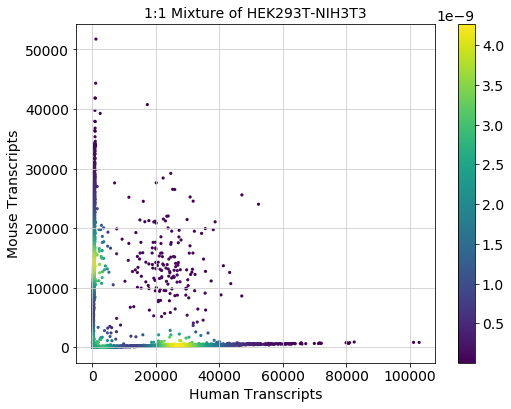

In [7]:
xy = np.vstack([adata.obs['counts_human'], adata.obs['counts_mouse']])
z = gaussian_kde(xy)(xy)
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(8,6))
plt.scatter(adata.obs['counts_human'], adata.obs['counts_mouse'], c=z, s=10, edgecolor='')
plt.title('1:1 Mixture of HEK293T-NIH3T3')
plt.xlabel('Human Transcripts')
plt.ylabel('Mouse Transcripts')
plt.colorbar()

# Plot number of transcripts detected in human and mouse cells

Text(0,0.5,'Number of transcripts')

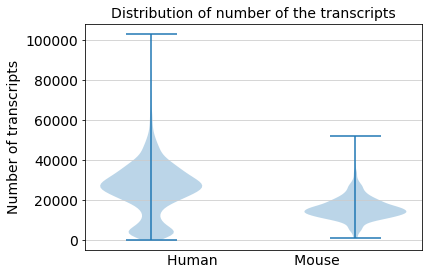

In [8]:
adata_mouse = adata.obs[(adata.obs['counts_human']<adata.obs['counts_total']*0.05)]
adata_human = adata.obs[(adata.obs['counts_mouse']<adata.obs['counts_total']*0.05)]
#len(adata_mouse['counts_mouse'])
#len(adata_human['counts_human'])
plt.violinplot(dataset = [adata_human[:]['counts_human'], adata_mouse[:]['counts_mouse']])
plt.title('Distribution of number of the transcripts')
plt.xticks([])
plt.xlabel('Human                 Mouse')
plt.ylabel('Number of transcripts')

In [9]:
adata.obs.index = adata.obs.index + "-1"

In [10]:
adata.obs.to_csv('../comparison_hgmm6k/counts_salmon.csv', sep=',')